In [1]:
import numpy as np
import healpy as hp
import skyproj
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import astropy.coordinates
from astropy import units as u
from scipy import stats
import galstreams #contains stream data
%matplotlib inline

## Functions

In [2]:
def change_coord(m, coord):   
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

 # from https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system

In [3]:
def plot_gcs(sp,gcs=None,gclist=None,annotate=False,cmap_name='plasma',norm=None):
    """ plots globular clusters from Vasiliev & Baumgardt 2021

    Parameters
    ----------
    sp : skyproj object
      map on which to plot the galaxies
    gcs : astropy table
      table of GC data
    gclist : list or array of integers
      list of indices into gcs for clusters to plot
    annotate : boolean
      whether or not to annotate clusters with names
      
    Returns
    -------
    cbh : figure handle containing information needed to produce a colorbar 
    
    Example
    -------
    Plot all the GCs on a predefined skyproj
    >>>> plot_gcs(sp)
    """

    from matplotlib.colors import LogNorm
    
    #download catalog
    if gcs is None:
        gcs = read_gcs()

    if gclist is not None:
        gcs = gcs[gclist]
        
    #extract sky coordinates
    gcradec = astropy.coordinates.SkyCoord(gcs['RAJ2000'],gcs['DEJ2000'])
    #set up the colormap (log distance)
    cmap = plt.get_cmap(cmap_name)
    if norm is None:
        norm = LogNorm(vmin=1.0,vmax=100.)

    dists = 1./gcs["plx"]*u.kpc

    nodist = (dists<0) #negative parallaxes !
    #plot stuff without a good distance in gray
    sp.scatter(gcradec[nodist].galactic.l.value, gcradec[nodist].galactic.b.value, c='gray',  edgecolors= "black", s=20)
    #plot the globular clusters
    cbh = sp.scatter(gcradec[~nodist].galactic.l.value, gcradec[~nodist].galactic.b.value, c=dists[~nodist],  edgecolors= "black", cmap=cmap, norm=norm, s=20)

    if annotate:
        for i,l in enumerate(gcs['Name']):
            x,y = sp.proj(gcradec[i].galactic.l.deg, gcradec[i].galactic.b.deg)       
            r = 30
            costh = 2 * np.random.rand() - 1
            xt, yt = r*costh, r*np.sqrt(1-costh*costh)
            sp.ax.annotate(l, (x,y), (xt,yt),textcoords='offset points',arrowprops=dict(arrowstyle='-',color='k'),va='top',ha='left')

    return cbh

In [4]:
def get_footprint():
    import healpy as hp
    # Read maps with the "tiles" covered -- these are built from APT's outputs
    HLWAS_wide = hp.read_map('../data/HLWAS_WIDE_0328_APT994_1024.fits.gz')
    HLWAS_medium = hp.read_map('../data/HLWAS_MEDIUM_0328_APT994_1024.fits.gz')
    maps = [HLWAS_wide, HLWAS_medium]
    
    #combine maps
    combined_map = np.zeros_like(HLWAS_wide)
    for i, m in enumerate(maps):
        m[m==hp.UNSEEN] = 0.
        combined_map[m!=0] = (i+1)*1.0

    combined_map[combined_map <=0] = hp.UNSEEN # Fill back with UNSEEN
    combined_map = change_coord(combined_map,['C','G'])
    
    return combined_map


In [5]:
def get_gaia_map(verbose=False):
    import healpy as hp
    # read in healpix Gaia map
    filename = '../data/gaia_stellar_density_map_G_21_gal_nside_128_v0.fits'
    gaiamap = hp.read_map(filename)
    #rescale the map so it looks good
    gaiamap -= np.min(gaiamap)
    scale = np.std(gaiamap)*0.2
    if verbose: print(scale)
    scaled_gmap = np.asinh(gaiamap/scale)
    if verbose: stats.describe(scaled_gmap)
    return scaled_gmap

In [6]:
def get_custom_colorbar():
    from matplotlib.colors import ListedColormap
    import matplotlib
    # Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
    col_dict = {1: "palegreen", # "lightskyblue",
                2: "limegreen", # "dodgerblue",
                3: "firebrick"}
    
    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
    labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM", "GPS"])
    len_lab = len(labels)
    return cm, labels, col_dict

In [7]:
def read_gcs():
    """ reads globular clusters from Vasiliev & Baumgardt 2021

    Returns
    -------
    gcs : table of GC data 
    
    """

    #download catalog
    from astroquery.vizier import Vizier
    vizier = Vizier() 
    CATALOGUE = "J/MNRAS/505/5978/tablea1"
    vizier.ROW_LIMIT = -1
    gcs = vizier.get_catalogs(CATALOGUE)[0]

    return gcs

In [8]:
def select_gcs_in_footprint(fp, gcs=None):
    from astropy.coordinates import SkyCoord
    if gcs is None:
        gcs = read_gcs()
    gc_coords = SkyCoord(ra=gcs['RAJ2000'],dec=gcs['DEJ2000'])
    gn=[]
    gs=[]
    for i,gc in enumerate(gc_coords):
        ipix = hp.ang2pix(hp.get_nside(fp),gc.galactic.l.value, gc.galactic.b.value,lonlat=True)
        if not fp[ipix]==hp.UNSEEN:
            if gc.galactic.b.value > 0:
                gn.append(i)
            else:
                gs.append(i)

    gcs_north = np.array(gn)
    gcs_south = np.array(gs)

    print(len(gcs_north),'gcs in northern footprint')
    print(len(gcs_south),'gcs in southern footprint')
    return gcs_north, gcs_south
    
def select_gcs_in_gps_main(gcs=None):
    from astropy.coordinates import SkyCoord
    if gcs is None:
        gcs = read_gcs()
    gc_coords = SkyCoord(ra=gcs['RAJ2000'],dec=gcs['DEJ2000'])
    #set up list
    ggps = []
    #make a patch for the survey
    l_RGPS=[50.1, 30, 30, 26.5,26.5, 10, 10, -10, -10, -67, -67, -79, -79, -67, -67, -10, -10, 10, 10, 50.1, 50.1]*u.deg
    b_RGPS=[ 2, 2, 4.5, 4.5, 2, 2, 6, 6, 2, 2, 2.0, 2.0,-2.5,-2.5, -2, -2, -6, -6, -2, -2, 2]*u.deg
    GPS_coords = np.array([l_RGPS,b_RGPS]).T
    GPS_patch = mpatches.Polygon(GPS_coords,closed=True)
    for i,gc in enumerate(gc_coords):
        if GPS_patch.contains_point((gc.galactic.l.wrap_at(180*u.deg).value, gc.galactic.b.value)):
            ggps.append(i)
    gcs_gps = np.array(ggps)
    print(len(gcs_gps), 'gcs in GPS')
    return gcs_gps

In [9]:
def get_gptds_fields():
    """
    courtesy Bob Benjamin
    """
    from astropy.coordinates import SkyCoord
    
    tds_name =[ 
        'TDS_Carina', 
        'TDS_NGC_6334_6357', 
        'TDS_Galactic_Center_Q4', 
        'TDS_Galactic_Center_Q1', 
        'TDS_Serpens_South_W40', 
        'TDS_W43']
    tdsL =[ 
        [-73.8,-71.2],
        [-9.2, -6.6],
        [-2.8, -0.2],
        [0.1,  2.6 ],
        [26.5, 30.0 ],
        [29.3, 31.9]]
    tdsB =[ 
        [-1.0,  -0.2 ],
        [0.3,  1.1],
        [-0.5, 0.3],
        [-0.5, 0.3  ],
        [ 2.0, 4.5 ],
        [-0.5, 0.3 ]]
    gptds = {}
    for i,k in enumerate(tds_name):
        lmm = tdsL[i]
        bmm = tdsB[i]

        gptds[k]={}
        gptds[k]['lmin']=lmm[0]
        gptds[k]['lmax']=lmm[1]
        gptds[k]['bmin']=bmm[0]
        gptds[k]['bmax']=bmm[1]
        
        gptds[k]['vertices'] = np.array([[lmm[0],lmm[0],lmm[1],lmm[1]],[bmm[0],bmm[1],bmm[1],bmm[0]]])*u.deg
        
    return gptds

In [10]:
def plot_polar_projection(fp, whichpole, gclist=None, annotate=False, alph=1.0):
    
    
    # Create a custom colorbar for the  maps
    from matplotlib.colors import ListedColormap
    import matplotlib
    # Design the color mapping
    col_dict = {1: "palegreen", 
                2: "limegreen"}
    
    # Create a colormap from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Make patches for the legend
    patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
    patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
    
    # Define labels
    labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM"])
    len_lab = len(labels)

    fig, ax = plt.subplots(figsize=(8,8))
    if whichpole == 'S':
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])
        im, _, _, _ = sp.draw_hpxmap(fp, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    else:
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])
        im, _, _, _ = sp.draw_hpxmap(fp, lon_range=(0,360), lat_range=(10,90), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    
    
    cbh = plot_gcs(sp,gclist=gclist,annotate=annotate)
    shandles=[patch_HLWAS_m,patch_HLWAS_w]
    handles, labels = sp.ax.get_legend_handles_labels()
    shandles.extend(handles)
    
    sp.legend(handles=shandles, loc='upper left', ncol=2,  fontsize=10, bbox_to_anchor=(0.0,0.0, 1.0, 0.05))
    
    sp.ax.tick_params(axis="x", labelsize=14)
    sp.ax.tick_params(axis="y", labelsize=14)
    cb=plt.colorbar(cbh, shrink=0.8)
    cb.set_label(label='Distance (Mpc)', size=16)
    cb.ax.tick_params(labelsize=16)
    plt.tight_layout(h_pad=0.1,w_pad=0.1)
    
    return fig 
    

## Plotting

In [11]:
scaled_gmap = get_gaia_map()
cm, labels, col_dict = get_custom_colorbar()

In [12]:
# Add coordinates for GTBDS and HLTDS
gbtds_one = astropy.coordinates.SkyCoord('17h50m16.8700s', '-28d41m11.10s')
gbtds_two = astropy.coordinates.SkyCoord('17h49m53.4700s','-28d49m31.00s')
elais_n1 = astropy.coordinates.SkyCoord('16h10m1.0000s', '+54d30m36.00s')
euclid_s_wide = astropy.coordinates.SkyCoord('04h14m24.0000s', '-47d36m0.00s')
euclid_s_deep = astropy.coordinates.SkyCoord('03h55m36.0000s', '-49d19m12.00s')
hlwas_cosmos = astropy.coordinates.SkyCoord('10h00m24.0000s', '+02d10m55.00s')
hlwas_xmm = astropy.coordinates.SkyCoord('02h22m50.0000s', '-04d45m0.00s')

In [13]:
# add coordinates for GPTDS fields
gptds = get_gptds_fields()

### just GPS in the plane

In [14]:
l_RGPS=[50.1, 30, 30, 26.5,26.5, 10, 10, -10, -10, -67, -67, -79, -79, -67, -67, -10, -10, 10, 10, 50.1, 50.1]*u.deg
b_RGPS=[ 2, 2, 4.5, 4.5, 2, 2, 6, 6, 2, 2, 2.0, 2.0,-2.5,-2.5, -2, -2, -6, -6, -2, -2, 2]*u.deg

In [15]:
alph = 1.0
from matplotlib.colors import Normalize

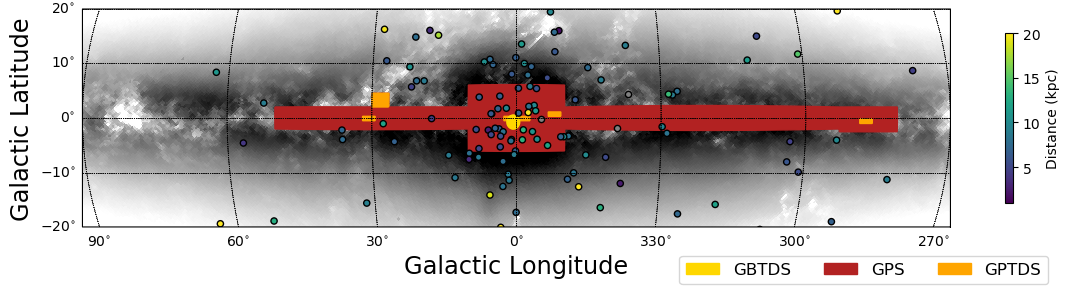

In [16]:
fig = plt.figure(1, figsize=(14, 11))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-90,90, -20, 20], galactic=True, min_lon_ticklabel_delta=0.06)
sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0)
#sp.draw_milky_way()
#GPS = hp.read_map('../data/GPS_ALL_0328_1024.fits.gz')
#GPS[GPS!=hp.UNSEEN]=3.
#GPS=change_coord(GPS,['C','G'])
#sp.draw_hpxmap(GPS, lon_range=(-90,90), lat_range=(-20, 20), alpha=alph, vmin=1, vmax=3, cmap=cm)
sp.set_extent([-90,90, -20, 20])
sp.draw_polygon(l_RGPS.value,b_RGPS.value,edgecolor='none',linestyle='solid',facecolor='firebrick')
[sp.draw_polygon(gptds[k]['vertices'][0],gptds[k]['vertices'][1],edgecolor='none',linestyle='solid',facecolor='orange') for k in gptds.keys()]
#GBTDS
sp.circle(gbtds_one.galactic.l.value, gbtds_one.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
sp.circle(gbtds_two.galactic.l.value, gbtds_two.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
cbh=plot_gcs(sp,cmap_name='viridis',norm=Normalize(vmin=1.0,vmax=20.0))


#legend stuff
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')
patch_GPTDS = mpatches.Patch(color='orange', label='GPTDS')
handles, labels = sp.ax.get_legend_handles_labels()
shandles = handles[0:1]

shandles.extend([patch_GPS,patch_GPTDS])




box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0.4, -0.3, 1.0, 0.55), fontsize=12)

plt.colorbar(cbh,label='Distance (kpc)', shrink=0.2)
plt.savefig('../figures/gps_footprints_gcs.png',dpi=200,bbox_inches='tight')
plt.show()

### Whole sky 

In [18]:
combined_map = get_footprint()

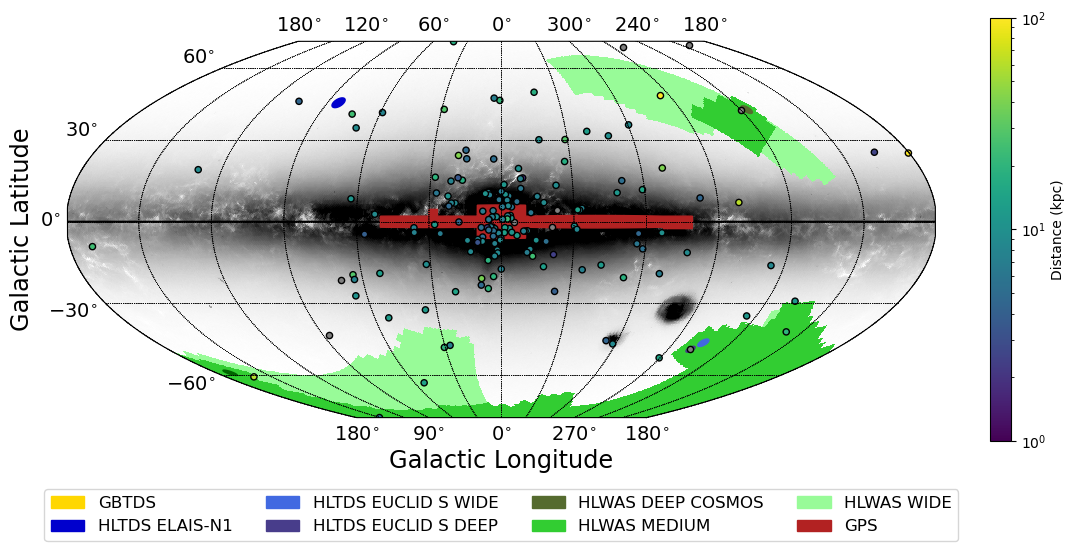

In [19]:
fig = plt.figure(1, figsize=(14, 11))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90], galactic=True, min_lon_ticklabel_delta=0.06)

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0)

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

sp.draw_milky_way(width=0,zorder=1)
#patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
#patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
#patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
sp.circle(gbtds_one.galactic.l.value, gbtds_one.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)

#gps
sp.draw_polygon(l_RGPS.value,b_RGPS.value,edgecolor='none',linestyle='solid',facecolor='firebrick')

#gbtds fields
#sp.draw_polygon(gptds['TDS_Carina']['vertices'][0],gptds['TDS_Carina']['vertices'][1],edgecolor='none',linestyle='solid',facecolor='orange')

cbh=plot_gcs(sp,cmap_name='viridis')



#make legend
handles, labels = sp.ax.get_legend_handles_labels()

# Make patches for the legend
patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

shandles = handles[0:5]
shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
shandles.extend([patch_GPS])
#shandles.extend(handles[5:])



box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
plt.colorbar(cbh,label='Distance (kpc)', shrink=0.5)
#plt.savefig('../figures/ccs_footprints_gcs.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_gcs.png',dpi=200,bbox_inches='tight')
plt.show()

### Find the GCs in the HLWAS

In [14]:
fp = get_footprint()

In [15]:
gcs_north, gcs_south = select_gcs_in_footprint(fp)

2 gcs in northern footprint
7 gcs in southern footprint


In [105]:
for i in gcs_north:
    out = gcs[i]['Name']+' & '
    out += '{0:=02.0f} {1:=02.0f} {2:=02.1f}'.format(gc_coords[i].ra.hms.h,gc_coords[i].ra.hms.m,gc_coords[i].ra.hms.s) 
    out += ' & '
    out += '{0:+d} {1:=02.0f} {2:=02.1f}'.format(int(gc_coords[i].dec.dms.d),np.abs(gc_coords[i].dec.dms.m),np.abs(gc_coords[i].dec.dms.s))
    out += ' & '
    lat = gc_coords[i].galactic.l.wrap_at(180*u.deg)
    out += '{0:+03d} {1:=02.0f} {2:=02.1f}'.format(int(lat.dms.d),np.abs(lat.dms.m),np.abs(lat.dms.s))
    out += ' & '
    out += '{0:+03d} {1:=02.0f} {2:=02.1f}'.format(int(gc_coords[i].galactic.b.dms.d),np.abs(gc_coords[i].galactic.b.dms.m),np.abs(gc_coords[i].galactic.b.dms.s))
    out += ' & '

    ipix = hp.ang2pix(hp.get_nside(fp),gc_coords[i].galactic.l.value, gc_coords[i].galactic.b.value,lonlat=True)
    if not fp[ipix]==hp.UNSEEN:
        which_s = labels[int(fp[ipix])-1][6:].lower()
        if gc_coords[i].galactic.b.value > 0: 
            which_s += ' N'
        else:
            which_s += ' S'
    out += which_s
    out += ' \\\\'
    print(out)

for i in gcs_south:
    out = gcs[i]['Name']+' & '
    out += '{0:=02.0f} {1:=02.0f} {2:=02.1f}'.format(gc_coords[i].ra.hms.h,gc_coords[i].ra.hms.m,gc_coords[i].ra.hms.s) 
    out += ' & '
    out += '{0:+d} {1:=02.0f} {2:=02.1f}'.format(int(gc_coords[i].dec.dms.d),np.abs(gc_coords[i].dec.dms.m),np.abs(gc_coords[i].dec.dms.s))
    out += ' & '
    lat = gc_coords[i].galactic.l.wrap_at(180*u.deg)
    out += '{0:+03d} {1:=02.0f} {2:=02.1f}'.format(int(lat.dms.d),np.abs(lat.dms.m),np.abs(lat.dms.s))
    out += ' & '
    out += '{0:+03d} {1:=02.0f} {2:=02.1f}'.format(int(gc_coords[i].galactic.b.dms.d),np.abs(gc_coords[i].galactic.b.dms.m),np.abs(gc_coords[i].galactic.b.dms.s))
    out += ' & '

    ipix = hp.ang2pix(hp.get_nside(fp),gc_coords[i].galactic.l.value, gc_coords[i].galactic.b.value,lonlat=True)
    if not fp[ipix]==hp.UNSEEN:
        which_s = labels[int(fp[ipix])-1][6:].lower()
        if gc_coords[i].galactic.b.value > 0: 
            which_s += ' N'
        else:
            which_s += ' S'
    out += which_s
    out += ' \\\\'
    print(out)

Pal 3 & 10 05 31.9 & +0 04 19.2 & -119 51 31.9 & +41 51 53.5 & medium N \\
Crater & 11 36 16.1 & -10 52 37.2 & -85 11 34.2 & +47 50 51.5 & wide N \\
NGC 288 & 00 52 45.1 & -26 34 58.8 & +151 15 56.6 & -89 22 51.5 & medium S \\
Whiting 1 & 02 02 56.9 & -3 15 10.8 & +161 37 1.1 & -60 38 10.8 & wide S \\
E 1 & 03 55 2.4 & -49 36 54.0 & -101 38 21.0 & -48 28 14.0 & medium S \\
Eridanus & 04 24 44.4 & -21 11 13.2 & -141 53 38.1 & -41 19 57.5 & medium S \\
NGC 7099 & 21 40 22.1 & -23 10 48.0 & +27 10 44.0 & -46 50 7.5 & wide S \\
Pal 12 & 21 46 38.9 & -21 15 10.8 & +30 30 34.7 & -47 40 54.9 & wide S \\
NGC 7492 & 23 08 26.6 & -15 36 39.6 & +53 23 13.3 & -63 28 38.1 & wide S \\


In [58]:
gcs[gcs_north]

Name,OName,RAJ2000,DEJ2000,pmRA,e_pmRA,pmDE,e_pmDE,corr,plx,e_plx,Rscale,Nstar,SimbadName
,,deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mas,mas,arcmin,,
str12,str10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,str26
Pal 3,,151.383,0.072,0.086,0.060,-0.148,0.071,-0.41,-0.001,0.050,0.71,61,Pal 3
Crater,Laevens 1,174.067,-10.877,-0.059,0.125,-0.116,0.116,-0.23,0.003,0.142,0.51,15,NAME Crater Cluster


In [59]:
gcs[gcs_south]

Name,OName,RAJ2000,DEJ2000,pmRA,e_pmRA,pmDE,e_pmDE,corr,plx,e_plx,Rscale,Nstar,SimbadName
,,deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mas,mas,arcmin,,
str12,str10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,str26
NGC 288,,13.188,-26.583,4.164,0.024,-5.705,0.024,0.01,0.141,0.011,2.79,4689,NGC 288
Whiting 1,,30.737,-3.253,-0.228,0.065,-2.046,0.056,0.03,0.017,0.047,0.52,40,Whiting 1
E 1,AM 1,58.760,-49.615,0.291,0.107,-0.177,0.086,-0.22,-0.015,0.062,0.36,58,E 1
Eridanus,,66.185,-21.187,0.510,0.039,-0.301,0.041,-0.09,0.050,0.033,0.52,44,NAME Eridanus Star Cluster
NGC 7099,M 30,325.092,-23.180,-0.737,0.025,-7.299,0.024,0.01,0.136,0.011,2.77,2990,NGC 7099
Pal 12,,326.662,-21.253,-3.220,0.029,-3.333,0.028,0.08,0.050,0.018,0.95,185,Pal 12
NGC 7492,,347.111,-15.611,0.756,0.028,-2.320,0.028,0.03,0.073,0.014,1.13,190,NGC 7492


### Galactic poles

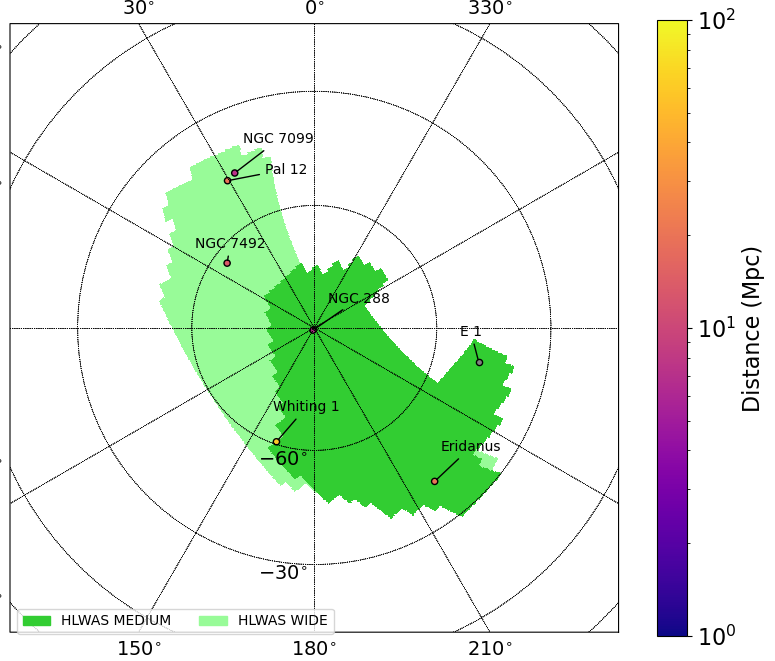

In [71]:
plot_polar_projection(fp, gclist=gcs_south, annotate=True,whichpole='S').savefig('../figures/ccs_footprints_gcs_south.png',dpi=200,bbox_inches='tight')

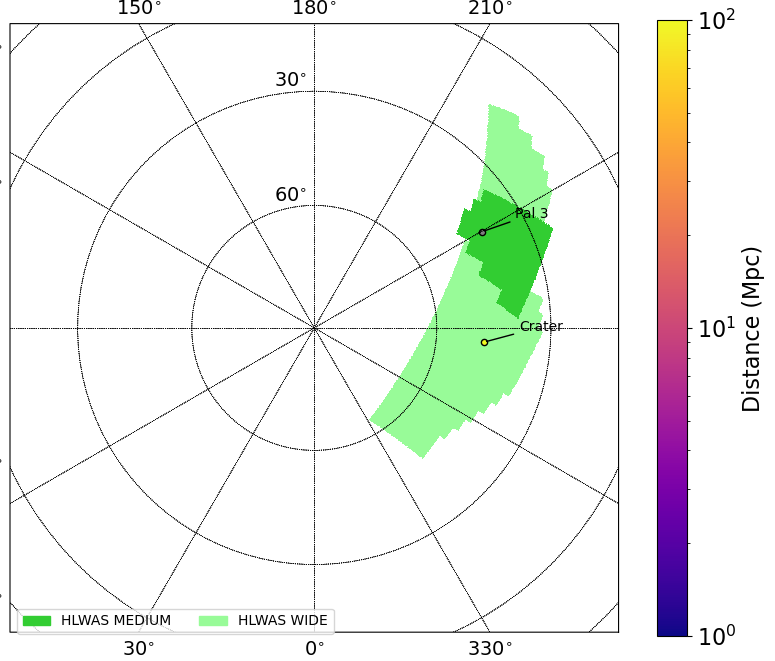

In [72]:
plot_polar_projection(fp, gclist=gcs_north, annotate=True, whichpole='N').savefig('../figures/ccs_footprints_gcs_north.png',dpi=200,bbox_inches='tight')

# find GCs in GPS main

In [16]:
gcs_gps = select_gcs_in_gps_main()

37 gcs in GPS


In [18]:
gcs = read_gcs()

In [19]:
gcs[gcs_gps][['Name','RAJ2000','DEJ2000']]
gc_coords 

Name,RAJ2000,DEJ2000
,deg,deg
str12,float32,float32
FSR 1716,242.625,-53.749
FSR 1735,253.044,-47.058
NGC 6304,258.634,-29.462
NGC 6316,259.155,-28.140
NGC 6355,260.994,-26.353
Terzan 2,261.888,-30.802
Terzan 4,262.663,-31.596
BH 229,262.772,-29.982


In [23]:
from astropy.coordinates import SkyCoord
i=gcs_gps[0]
gc_coords = SkyCoord(ra=gcs['RAJ2000'],dec=gcs['DEJ2000'])

In [46]:
test=gc_coords[0]
'{0:=02.0f} {1:0.1f} {2:0.2f}'.format(test.ra.hms.h,test.ra.hms.m,test.ra.hms.s)

'00 24.0 5.76'

In [47]:
'{0:=02.0f} {1:0.1f} {2:0.2f}'.format(gc_coords[i].ra.hms.h,gc_coords[i].ra.hms.m,gc_coords[i].ra.hms.s)

'16 10.0 30.00'

In [59]:
test.dec.dms

dms_tuple(d=np.float32(-72.0), m=np.float32(-4.0), s=np.float32(-51.604614))

In [69]:
'{0:+=02.0f} {1:0.0f} {2:0.1f}'.format(-gc_coords[i].dec.dms.d,np.abs(gc_coords[i].dec.dms.m),np.abs(gc_coords[i].dec.dms.s))

'+5 11 31.2'

In [73]:
'{0:=03.0f} {1:0.0f} {2:0.1f}'.format(test.galactic.l.dms.d,test.galactic.l.dms.m,test.galactic.l.dms.s)

'305 53 41.0'

In [82]:
'{0:+=02.0f} {1:0.0f} {2:0.1f}'.format(test.galactic.b.dms.d,np.abs(test.galactic.b.dms.m),np.abs(test.galactic.b.dms.s))

'-44 53 22.7'

In [102]:

for i in gcs_gps:
    out = gcs[i]['Name']+' & '
    out += '{0:=02.0f} {1:=02.0f} {2:=02.1f}'.format(gc_coords[i].ra.hms.h,gc_coords[i].ra.hms.m,gc_coords[i].ra.hms.s) 
    out += ' & '
    out += '{0:+d} {1:=02.0f} {2:=02.1f}'.format(int(gc_coords[i].dec.dms.d),np.abs(gc_coords[i].dec.dms.m),np.abs(gc_coords[i].dec.dms.s))
    out += ' & '
    lat = gc_coords[i].galactic.l.wrap_at(180*u.deg)
    out += '{0:+03d} {1:=02.0f} {2:=02.1f}'.format(int(lat.dms.d),np.abs(lat.dms.m),np.abs(lat.dms.s))
    out += ' & '
    out += '{0:+03d} {1:=02.0f} {2:=02.1f}'.format(int(gc_coords[i].galactic.b.dms.d),np.abs(gc_coords[i].galactic.b.dms.m),np.abs(gc_coords[i].galactic.b.dms.s))
    out += ' \\\\'
    print(out)

FSR 1716 & 16 10 30.0 & -53 44 56.4 & -30 13 19.2 & -01 35 33.5 \\
FSR 1735 & 16 52 10.6 & -47 03 28.8 & -20 48 44.6 & -01 51 11.2 \\
NGC 6304 & 17 14 32.2 & -29 27 43.2 & -04 10 28.4 & +05 22 33.0 \\
NGC 6316 & 17 16 37.2 & -28 08 24.0 & -02 49 29.1 & +05 45 53.5 \\
NGC 6355 & 17 23 58.6 & -26 21 10.8 & +00 24 53.3 & +05 25 41.8 \\
Terzan 2 & 17 27 33.1 & -30 48 7.2 & -03 40 49.1 & +02 17 53.7 \\
Terzan 4 & 17 30 39.1 & -31 35 45.6 & -03 58 34.1 & +01 18 25.5 \\
BH 229 & 17 31 5.3 & -29 58 55.2 & -02 34 29.6 & +02 06 52.6 \\
Liller 1 & 17 33 24.5 & -33 23 24.0 & -05 09 36.8 & +00 09 38.3 \\
NGC 6380 & 17 34 28.1 & -39 04 8.4 & -09 49 5.6 & -03 25 13.9 \\
Terzan 1 & 17 35 47.0 & -30 28 51.6 & -02 26 31.5 & +00 59 31.2 \\
Ton 2 & 17 36 10.6 & -38 33 10.8 & -09 12 11.4 & -03 25 23.8 \\
NGC 6401 & 17 38 36.5 & -23 54 36.0 & +03 26 59.9 & +03 58 48.2 \\
VVV CL002 & 17 41 6.2 & -28 50 42.0 & +00 26 29.3 & +00 53 20.8 \\
Pal 6 & 17 43 42.2 & -26 13 22.8 & +02 05 30.4 & +01 46 47.0 \\
Djorg 1